In [555]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import pymc3 as pm
import seaborn as sns
import theano.tensor as T
from theano import shared


# 1. Read and prepare data

In [497]:
ds = pd.read_csv('employee_retention_data.csv', index_col = 0)
ds.head()

,company_id,dept,seniority,salary,join_date,quit_date
employee_id,,,,,,
13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
927315.0,4,marketing,14,101000.0,2014-10-13,NaN
662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [498]:
print('Total number of records: %d' %len(ds))

Total number of records: 24702


## 1.1 Feature transformation

### Company id and department name: one-hot-encoding

In [499]:
# since relatively large number of data - use one-hot-encoding
ds.company_id = ds.company_id.astype(str).copy()
ds.salary = np.log10(ds.salary)
ds_2 = pd.get_dummies(ds, columns = ['company_id', 'dept'])
ds_2.head()

,seniority,salary,join_date,quit_date,company_id_1,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,...,company_id_6,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
employee_id,,,,,,,,,,,,,,,,,,,,,
13021.0,28,4.949390,2014-03-24,2015-10-30,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
825355.0,20,5.262451,2013-04-29,2014-04-04,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
927315.0,14,5.004321,2014-10-13,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
662910.0,20,5.060698,2012-05-14,2013-06-07,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
256971.0,23,5.440909,2011-10-17,2014-08-22,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### Start and quit time: timestamp

In [500]:
ds_3 = ds_2.copy()
ds_3.join_date = pd.to_datetime(ds_2.join_date, format="%Y-%m-%d")
quit_date = [pd.to_datetime(ds_2.iloc[i].quit_date, format='%Y-%m-%d') 
            if ~pd.isnull(ds_2.iloc[i].quit_date) 
            else np.NaN 
            for i in range(len(ds_2))]
ds_3.quit_date = quit_date

## 1.2 Label the data

In [501]:
# add a column of whether the employee stayed of not
ds_3['quited'] = ~pd.isnull(ds_3.quit_date)
# check class balance
print('Quited fraction in dataset: %f' % (sum(ds_3.quited)/len(ds_3)))
# add a column of length of stay
# ds_3['length'] = ds_3.quit_date - ds_3.join_date

Quited fraction in dataset: 0.546919


In [502]:
ds_3.head()

,seniority,salary,join_date,quit_date,company_id_1,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,...,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,quited
employee_id,,,,,,,,,,,,,,,,,,,,,
13021.0,28,4.949390,2014-03-24,2015-10-30,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,True
825355.0,20,5.262451,2013-04-29,2014-04-04,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,True
927315.0,14,5.004321,2014-10-13,NaT,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,False
662910.0,20,5.060698,2012-05-14,2013-06-07,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,True
256971.0,23,5.440909,2011-10-17,2014-08-22,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,True


# 2. Build a classifier to predict retention

In [503]:
y_c = ds_3.quited
X_c = ds_3.copy().drop(columns = ['join_date', 'quit_date', 'quited'])
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3, random_state=1)

## 2.1 Base model: logistic regression

In [504]:
# base model - logistic regression
k_fold = KFold(5, shuffle=True)
lr = LogisticRegression()
score = np.zeros(5)
mse = np.zeros(5)
for k, (train_k, test_k) in enumerate(k_fold.split(X_train, y_train)):
    lr.fit(X_train.iloc[train_k], y_train.iloc[train_k])
    score[k] = lr.score(X_train.iloc[test_k], y_train.iloc[test_k])
    print('%s iteration accuracy: %.02f' %(k, lr.score(X_train.iloc[test_k], y_train.iloc[test_k])))
    y_pred = lr.predict(X_train.iloc[test_k])
    
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))

0 iteration accuracy: 0.56
1 iteration accuracy: 0.55
2 iteration accuracy: 0.55
3 iteration accuracy: 0.54
4 iteration accuracy: 0.55
Accuracy: 0.55 (+/- 0.01)


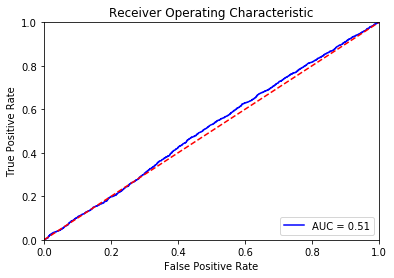

In [505]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
y_pred = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.2 RadomForest classifier

In [506]:
# train a RF classifier
k_fold = KFold(5, shuffle=True)
rfc = RandomForestClassifier(warm_start=False)
score = np.zeros(5)
mse = np.zeros(5)
for k, (train_k, test_k) in enumerate(k_fold.split(X_train, y_train)):
    rfc.fit(X_train.iloc[train_k], y_train.iloc[train_k])
    score[k] = rfc.score(X_train.iloc[test_k], y_train.iloc[test_k])
    print('%s iteration accuracy: %.02f' %(k, rfc.score(X_train.iloc[test_k], y_train.iloc[test_k])))
    y_pred = rfc.predict(X_train.iloc[test_k])
    
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))

0 iteration accuracy: 0.51
1 iteration accuracy: 0.51
2 iteration accuracy: 0.50
3 iteration accuracy: 0.52
4 iteration accuracy: 0.50
Accuracy: 0.51 (+/- 0.01)


In [507]:
# check the confusion matrix
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1595, 1720],
       [1933, 2163]])

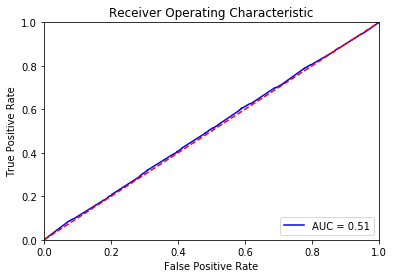

In [508]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rfc.predict_proba(X_test)
y_pred = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.3 Gradient boosting classifier

In [509]:
# train a gb classifier
k_fold = KFold(5, shuffle=True)
gbc = GradientBoostingClassifier(warm_start=False)
score = np.zeros(5)
mse = np.zeros(5)
for k, (train_k, test_k) in enumerate(k_fold.split(X_train, y_train)):
    gbc.fit(X_train.iloc[train_k], y_train.iloc[train_k])
    score[k] = gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])
    print('%s iteration accuracy: %.02f' %(k, gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])))
    y_pred = gbc.predict(X_train.iloc[test_k])
    
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))

0 iteration accuracy: 0.54
1 iteration accuracy: 0.57
2 iteration accuracy: 0.56
3 iteration accuracy: 0.56
4 iteration accuracy: 0.57
Accuracy: 0.56 (+/- 0.01)


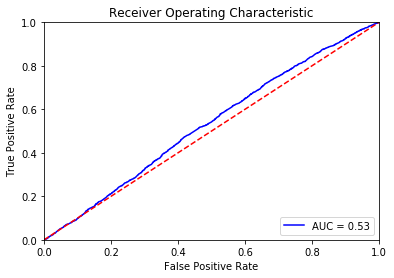

In [510]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gbc.predict_proba(X_test)
y_pred = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.4 Fine-tuned gradient boosting classifier performed slightly better than the other model

In [511]:
# train a gb classifier
k_fold = KFold(5, shuffle=True)
gbc = GradientBoostingClassifier(n_estimators=100, subsample=.7, warm_start=True, random_state=0)
score = np.zeros(5)
mse = np.zeros(5)
for k, (train_k, test_k) in enumerate(k_fold.split(X_train, y_train)):
    gbc.fit(X_train.iloc[train_k], y_train.iloc[train_k])
    score[k] = gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])
    print('%s iteration accuracy: %.02f' %(k, gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])))
    y_pred = gbc.predict(X_train.iloc[test_k])
    
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))


0 iteration accuracy: 0.55
1 iteration accuracy: 0.60
2 iteration accuracy: 0.60
3 iteration accuracy: 0.57
4 iteration accuracy: 0.59
Accuracy: 0.58 (+/- 0.02)


In [512]:
# check the confusion matrix
y_pred = gbc.predict(X_test)
print('Test accuracy: %f' % accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


Test accuracy: 0.556875


array([[ 718, 2597],
       [ 687, 3409]])

# 3. Feature engineering

## 3.1 Normalize salary by length of stay

In [513]:
# length of stay: if quited, length of stay = quited date - join date; 
# if not, length of stay = latest join date - join date + 1
maxdate = ds_3.join_date.max()
ds_3['DaysSinceJoin'] = [(maxdate - ds_3.iloc[i].join_date).days + 1
                      if ~ds_3.quited.iloc[i]
                      else (ds_3.iloc[i].quit_date - ds_3.iloc[i].join_date).days 
                      for i in range(len(ds_3))]
ds_3['NormalizedSalary'] = ds_3.salary / ds_3.DaysSinceJoin
ds_3.head()

,seniority,salary,join_date,quit_date,company_id_1,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,...,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,quited,DaysSinceJoin,NormalizedSalary
employee_id,,,,,,,,,,,,,,,,,,,,,
13021.0,28,4.949390,2014-03-24,2015-10-30,0,0,0,0,0,0,...,0,1,0,0,0,0,0,True,585,0.008460
825355.0,20,5.262451,2013-04-29,2014-04-04,0,0,0,0,0,0,...,0,0,0,0,0,1,0,True,340,0.015478
927315.0,14,5.004321,2014-10-13,NaT,0,0,0,0,0,0,...,0,0,0,0,0,1,0,False,424,0.011803
662910.0,20,5.060698,2012-05-14,2013-06-07,0,0,0,0,0,0,...,0,1,0,0,0,0,0,True,389,0.013010
256971.0,23,5.440909,2011-10-17,2014-08-22,0,0,0,0,1,0,...,0,0,1,0,0,0,0,True,1040,0.005232


In [514]:
y_c_3 = ds_3.quited
X_c_3 = ds_3.copy().drop(columns = ['join_date', 'quit_date', 'quited'])
X_train, X_test, y_train, y_test = train_test_split(X_c_3, y_c_3, test_size=0.3, random_state=1)

## 3.2 New features based on normalized salary and length of stay improved the accuracy of the classifer.

In [515]:
# train a gb classifier
k_fold = KFold(5, shuffle=True)
gbc = GradientBoostingClassifier(n_estimators=100, subsample=.7, warm_start=True, random_state=0)
score = np.zeros(5)
mse = np.zeros(5)
for k, (train_k, test_k) in enumerate(k_fold.split(X_train, y_train)):
    gbc.fit(X_train.iloc[train_k], y_train.iloc[train_k])
    score[k] = gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])
    print('%s iteration accuracy: %.02f' %(k, gbc.score(X_train.iloc[test_k], y_train.iloc[test_k])))
    y_pred = gbc.predict(X_train.iloc[test_k])
    
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))


0 iteration accuracy: 0.75
1 iteration accuracy: 0.77
2 iteration accuracy: 0.77
3 iteration accuracy: 0.78
4 iteration accuracy: 0.77
Accuracy: 0.77 (+/- 0.01)


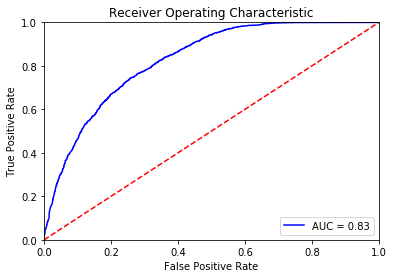

In [516]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gbc.predict_proba(X_test)
y_pred = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [517]:
# check the confusion matrix
y_pred = gbc.predict(X_test)
print('Test accuracy: %f' % accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


Test accuracy: 0.747403


array([[1983, 1332],
       [ 540, 3556]])

## 3.3 Top 5 most important features from the model

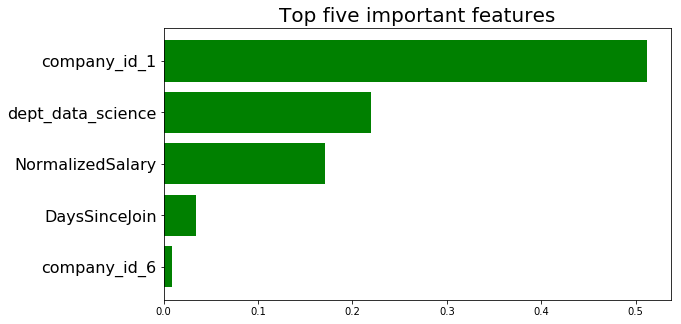

Feature ranking:
1. feature company_id_1 (0.511578)
2. feature dept_data_science (0.219656)
3. feature NormalizedSalary (0.171320)
4. feature DaysSinceJoin (0.034125)
5. feature company_id_6 (0.009336)
6. feature company_id_11 (0.008087)
7. feature company_id_12 (0.007906)
8. feature company_id_3 (0.006533)
9. feature company_id_2 (0.006027)
10. feature company_id_9 (0.005486)


In [518]:
# Plot the top 5 important features of the forest
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

names = []
for i in indices:
    if X_train.columns[indices[i]][0] == 'f':
        names.append(X_train.columns[remain_idx][indices[i]][3:])
    else:
        names.append(X_train.columns[indices[i]])
std = np.std([gbc.feature_importances_ for tree in gbc.estimators_],
             axis=0)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Top five important features", fontsize=20)
plt.barh(range(5), importances[indices][0:5],
       color="g", yerr=std[indices][0:5], align="center")
plt.yticks(range(5), indices, fontsize=16)
plt.yticks(range(5), names[0:5])
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

# 4. Hierarchical models to account for company and department variance 

From the above feature importance score, it seems that there is large variation between companies in terms of overall retention rate, giving that individual company 1 and 6 showed up as important classification features.

I next intended to build a hierarchical classifier accounting for the inter-company variance. 

## 4.1 Relabel the data for hierarchical model.

In [520]:
le = preprocessing.LabelEncoder()
ds_4 = ds.copy()
temp = le.fit_transform(ds_4.dept)
ds_4.dept = temp
ds_4.head()

,company_id,dept,seniority,salary,join_date,quit_date
employee_id,,,,,,
13021.0,7,0,28,4.949390,2014-03-24,2015-10-30
825355.0,7,4,20,5.262451,2013-04-29,2014-04-04
927315.0,4,4,14,5.004321,2014-10-13,NaN
662910.0,7,0,20,5.060698,2012-05-14,2013-06-07
256971.0,2,1,23,5.440909,2011-10-17,2014-08-22


In [521]:
ds_4['quited'] = ds_3.quited
ds_4['DaysSinceJoin'] = ds_3.DaysSinceJoin
ds_4['NormalizedSalary'] = ds_3.NormalizedSalary

In [522]:
y_c_4 = ds_4.quited
X_c_4 = ds_4.copy().drop(columns = ['join_date', 'quit_date', 'quited'])
X_train, X_test, y_train, y_test = train_test_split(X_c_4, y_c_4, test_size=0.3, random_state=1)

In [523]:
X_train.head()

,company_id,dept,seniority,salary,DaysSinceJoin,NormalizedSalary
employee_id,,,,,,
571671.0,1,3,26,5.463893,25,0.218556
249324.0,1,1,25,5.498311,501,0.010975
312892.0,6,0,5,4.845098,760,0.006375
732535.0,8,0,12,4.792392,1172,0.004089
184346.0,3,5,25,5.176091,340,0.015224


In [524]:
observed = [1 if y_train.iloc[i] == True else 0 for i in range(len(y_train))]
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

## 4.2 Use Pymc3 to build a hierarchical logistic classifier.

In [569]:
ds_5 = ds_4.copy()
ds_5['quited_2'] = [1 if ds_5.iloc[i]['quited'] == True else 0 for i in range(len(ds_5))]
y_c_5 = ds_5.quited_2
X_c_5 = ds_5.copy().drop(columns = ['join_date', 'quit_date', 'quited', 'quited_2'])
company_id = ds_5.company_id.values.astype(int)-1
X_c_5['company_id'] = company_id
X_train, X_test, y_train, y_test = train_test_split(X_c_5, y_c_5, test_size=0.3, random_state=1)


In [579]:
with pm.Model() as hierarchical_logistic_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b1 = pm.Normal('mu_beta1', mu=0., sd=1)
    sigma_b1 = pm.HalfCauchy('sigma_beta1', beta=1)
    mu_b2 = pm.Normal('mu_beta2', mu=0., sd=1)
    sigma_b2 = pm.HalfCauchy('sigma_beta2', beta=1)
    mu_b3 = pm.Normal('mu_beta3', mu=0., sd=1)
    sigma_b3 = pm.HalfCauchy('sigma_beta3', beta=1)
    mu_b4 = pm.Normal('mu_beta4', mu=0., sd=1)
    sigma_b4 = pm.HalfCauchy('sigma_beta4', beta=1)
    mu_b5 = pm.Normal('mu_beta5', mu=0., sd=1)
    sigma_b5 = pm.HalfCauchy('sigma_beta5', beta=1)
    
    n_company = len(X_train.company_id.unique())
    
    # Intercept for each company, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_company)
    # coefficient for each company, distributed around group mean mu_a
    b1 = pm.Normal('beta1', mu=mu_b1, sd=sigma_b1, shape=n_company)
    b2 = pm.Normal('beta2', mu=mu_b2, sd=sigma_b2, shape=n_company)
    b3 = pm.Normal('beta3', mu=mu_b3, sd=sigma_b3, shape=n_company)
    b4 = pm.Normal('beta4', mu=mu_b4, sd=sigma_b4, shape=n_company)
    b5 = pm.Normal('beta5', mu=mu_b5, sd=sigma_b5, shape=n_company)
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # inverse logit using theano syntax
    a_inv = pm.Deterministic('a_inv', T.exp(a)/(1 + T.exp(a)))
    fin = pm.Deterministic('fin', T.exp(a + b1 + b2 + b3 + b4 + b5)/(1 + T.exp(a + b1 + b2 + b3 + b4 + b5)))
    
    # Turn features into a shared var so that can change it later
    X_train_shared = shared(X_train.values)
    company_id = X_train['company_id'] 
    # Expected value
    yhat = pm.invlogit(a[company_id] + b1[company_id] * X_train['dept'].values \
                + b2[company_id] * np.log10(X_train['seniority'].values)\
                + b3[company_id] * np.log10(X_train['salary'].values)\
                + b4[company_id] * np.log10(X_train['DaysSinceJoin'].values)\
                + b5[company_id] * np.log10(X_train['NormalizedSalary'].values))
    
    # Data likelihood
    y = pm.Binomial('y_like', n=np.ones(X_train.shape[0], dtype='int'), p = yhat, observed = y_train.values)

In [580]:
with hierarchical_logistic_model:
    hlog_trace = pm.sample(njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, beta5, beta4, beta3, beta2, beta1, alpha, sigma_beta5, mu_beta5, sigma_beta4, mu_beta4, sigma_beta3, mu_beta3, sigma_beta2, mu_beta2, sigma_beta1, mu_beta1, sigma_alpha, mu_alpha]
100%|██████████| 1000/1000 [2:01:27<00:00,  6.86s/it] 
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


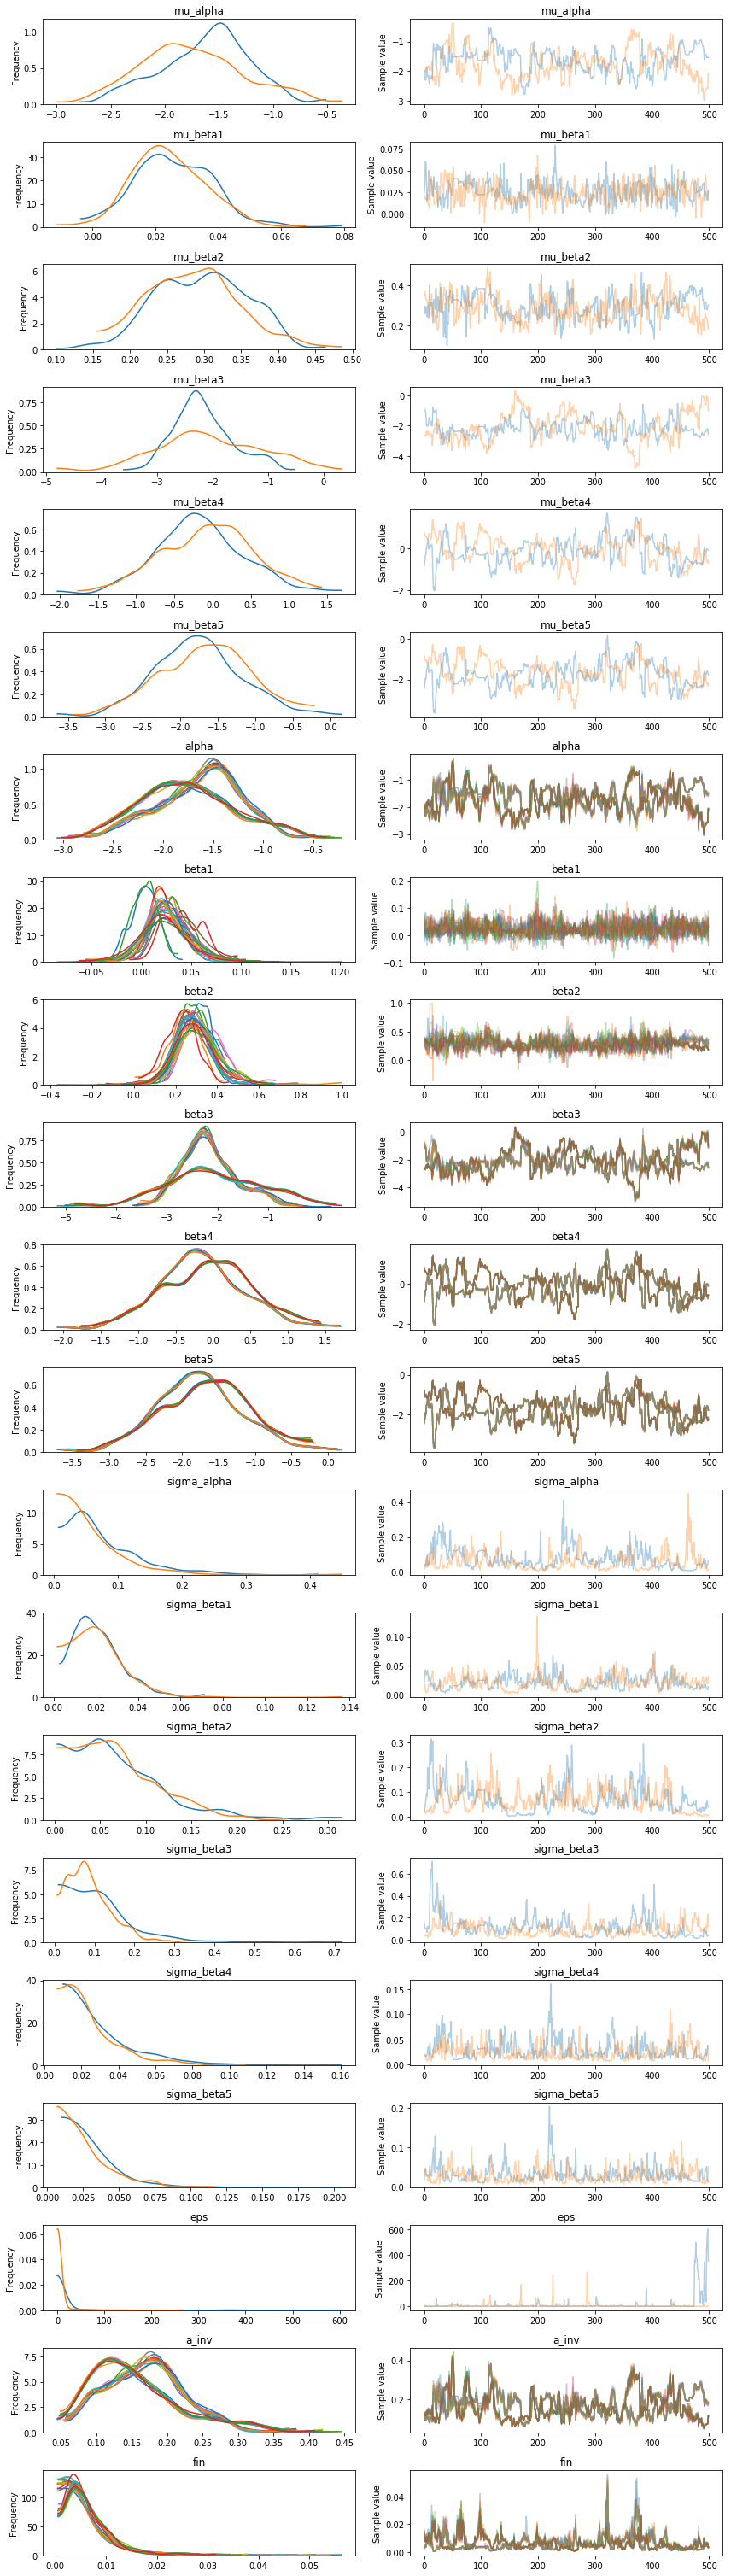

In [581]:
pm.traceplot(hlog_trace);

In [589]:
ppc = pm.sample_posterior_predictive(hlog_trace, samples=500, model=hierarchical_logistic_model)
y_replicas = [y_rep.mean() for y_rep in ppc['y_like']]


100%|██████████| 500/500 [00:01<00:00, 289.18it/s]


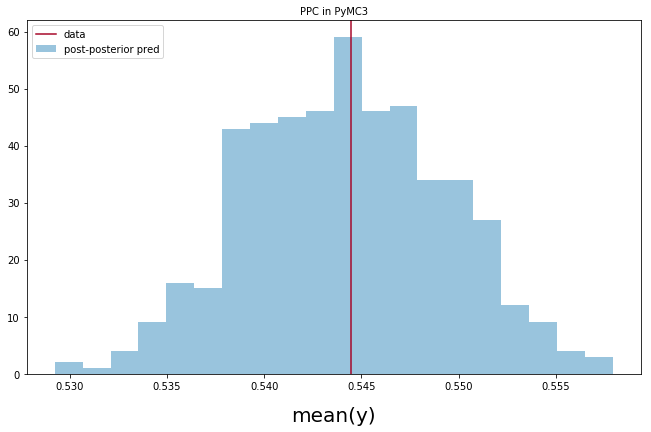

In [594]:
fig, ax = plt.subplots(1, figsize=(11, 6.5))
ax.hist(y_replicas, bins=20, alpha=0.5, color="#348ABD", histtype="stepfilled", label="post-posterior pred")
ax.axvline(y_train.values.mean(), color="#A60628", label="data")
ax.legend(loc=2, fontsize=10)
ax.set_xlabel("mean(y)", fontsize=20, labelpad=15)
_ = ax.set_title("PPC in PyMC3", fontsize=10)  

# 5. Conclusion and next steps

According to the gradient boosting tree model, the retention rate in this dataset is highly dependent on companies. Accorss companies, the important drivers are how long the employer stayed with the company and the salary normalized by the employer's length of stay.

According to the hierarchical logistic regression, the higher the salary and the normalized salary, the more likely the employee is going to leave. On the other hand, it seems that the more experience the person had before taking the job, the less likely he/she is going to quit.

In terms of next step, model wise, I'd like to 1) find a way to compare the hierarchical model with gradient boosting using test data, 2) do a grid-search to fine-tune the gradient boosting model and 3) build individual models for each company and/or department and compare them to the other models.

It will be helpful to have more data on the employee as well. For example, it seems that prior experience contributes positively to retention but this feature also correlates with the person's age and whether he or she has a family, both of which may play important role in people's decision of whether to leave a company or not.